# Parameterization training and ensemble runs

In [1]:
import sys
import os

In [2]:
if 'haicu' in os.getcwd() and 'haicu' not in sys.path: 
    PROJECT_DIR = "/home/haicu/birgit.kuehbacher/stochastic_uncertainty"
    sys.path.insert(1, os.path.join(PROJECT_DIR, 'notebooks'))
    sys.path.insert(1, os.path.join(PROJECT_DIR, 'src'))
    %cd stochastic_uncertainty/notebooks/
elif '../src' not in sys.path: 
    sys.path.insert(1, '../src')
else: 
    print("System path already modified.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.optimize as opt
import numpy.polynomial.polynomial as poly
import os
from pathlib import Path
import matplotlib.colors as mcolors

import flags

from models.lorenz96 import L96
from utils.saving import save_output_l96, save_output_gcm, save_output_ensemble, save_output_l96_ensemble_simulation
from plotting.lorenz96
from plotting.contour import *
from plotting.distribution import *

In [4]:
output_folder = 'output/test'
figures_folder  = 'output/test/figures/'
Path(output_folder).mkdir(parents=True, exist_ok=True)
Path(figures_folder).mkdir(parents=True, exist_ok=True)

extra_ident = ''

In [5]:
dpi = 150
save_plots = False
save_folder = figures_folder if save_plots else ""

Define parameters according to Arnold et al. 2013.

In [6]:
FLAGS = flags.Flags({
    'K': 8,  # Number of global-scale variables X
    'J': 32,  # Number of local-scale Y variables per single global-scale X variable
    'h': 1.0,  # Coupling coefficient
    'F': 20.0,  # Forcing
    'b': 10.0,  # spatial-scale ratio
    # time-scale ratio, 4 (small time-scale separation, hard) or 10 (large time-scale separation, easy)
    'c': 10.0,
})

In [7]:
FLAGS['seed'] = 17

In [8]:
t_total = 300
t_total_ens = 100

## Truth simulation: Two time-scale L96

In [9]:
FLAGS['solver'] = 'manual'
FLAGS['solver_method'] = 'DOP853' # RK45, DOP853 (RK8). Only used when 'method' is a scipy solver
FLAGS['si'] = 0.1
FLAGS['dt'] = 1e-3
FLAGS['t_total'] = t_total 
FLAGS['train_perc'] = 0.1
FLAGS['t_spin_up'] = 30

In [10]:
m = L96(FLAGS['K'], FLAGS['J'], FLAGS['F'], FLAGS['h'],
        FLAGS['b'], FLAGS['c'], seed=FLAGS['seed'])
# Spin up model 
# `store=True` saves the final state as an initial condition for the next run.
x, y, t = m.run(si=FLAGS['si'], t_total=FLAGS['t_spin_up'], store=True,
                solver=FLAGS['solver'], solver_method=FLAGS['solver_method'])
init_conditions = m.x

In [11]:
# Run the model and return the true coupling term u
%time x_true, y_true, t, u = \
    m.run(FLAGS['si'], FLAGS['t_total'], dt=FLAGS['dt'], solver=FLAGS['solver'], \
        solver_method=FLAGS['solver_method'], store=True, return_coupling=True)

CPU times: user 5.27 s, sys: 21.7 ms, total: 5.29 s
Wall time: 5.36 s


In [12]:
save_output_l96(output_folder, FLAGS, x_true, y_true, t, u, extra_ident=extra_ident)

### Plots

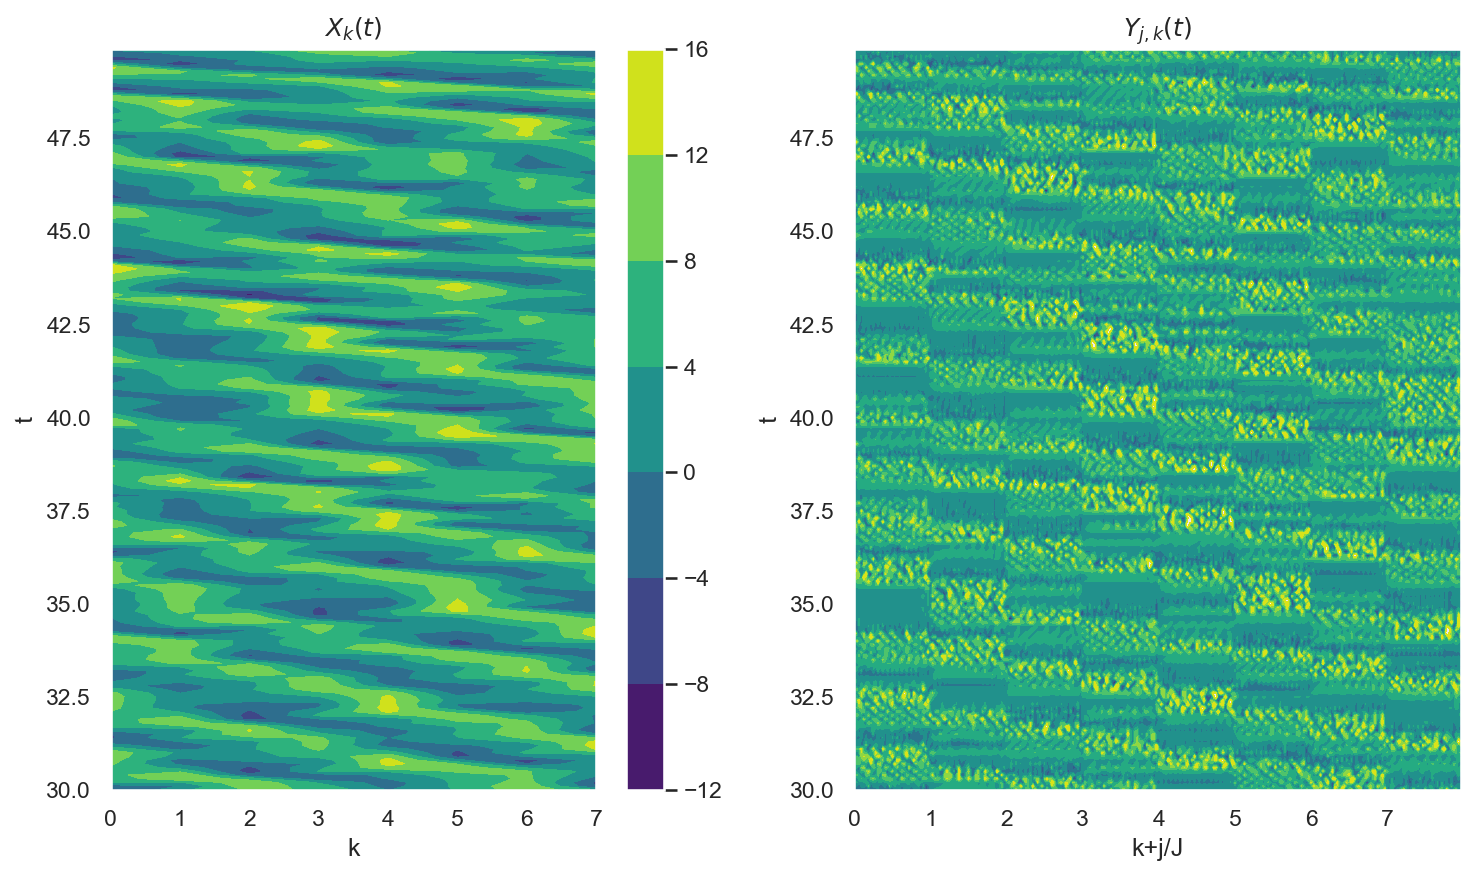

In [13]:
time_end = 200
fig = plot_l96_x_and_y(x_true, y_true, t, time_end, dpi=dpi, output_folder=save_folder, config=FLAGS)
plt.show()

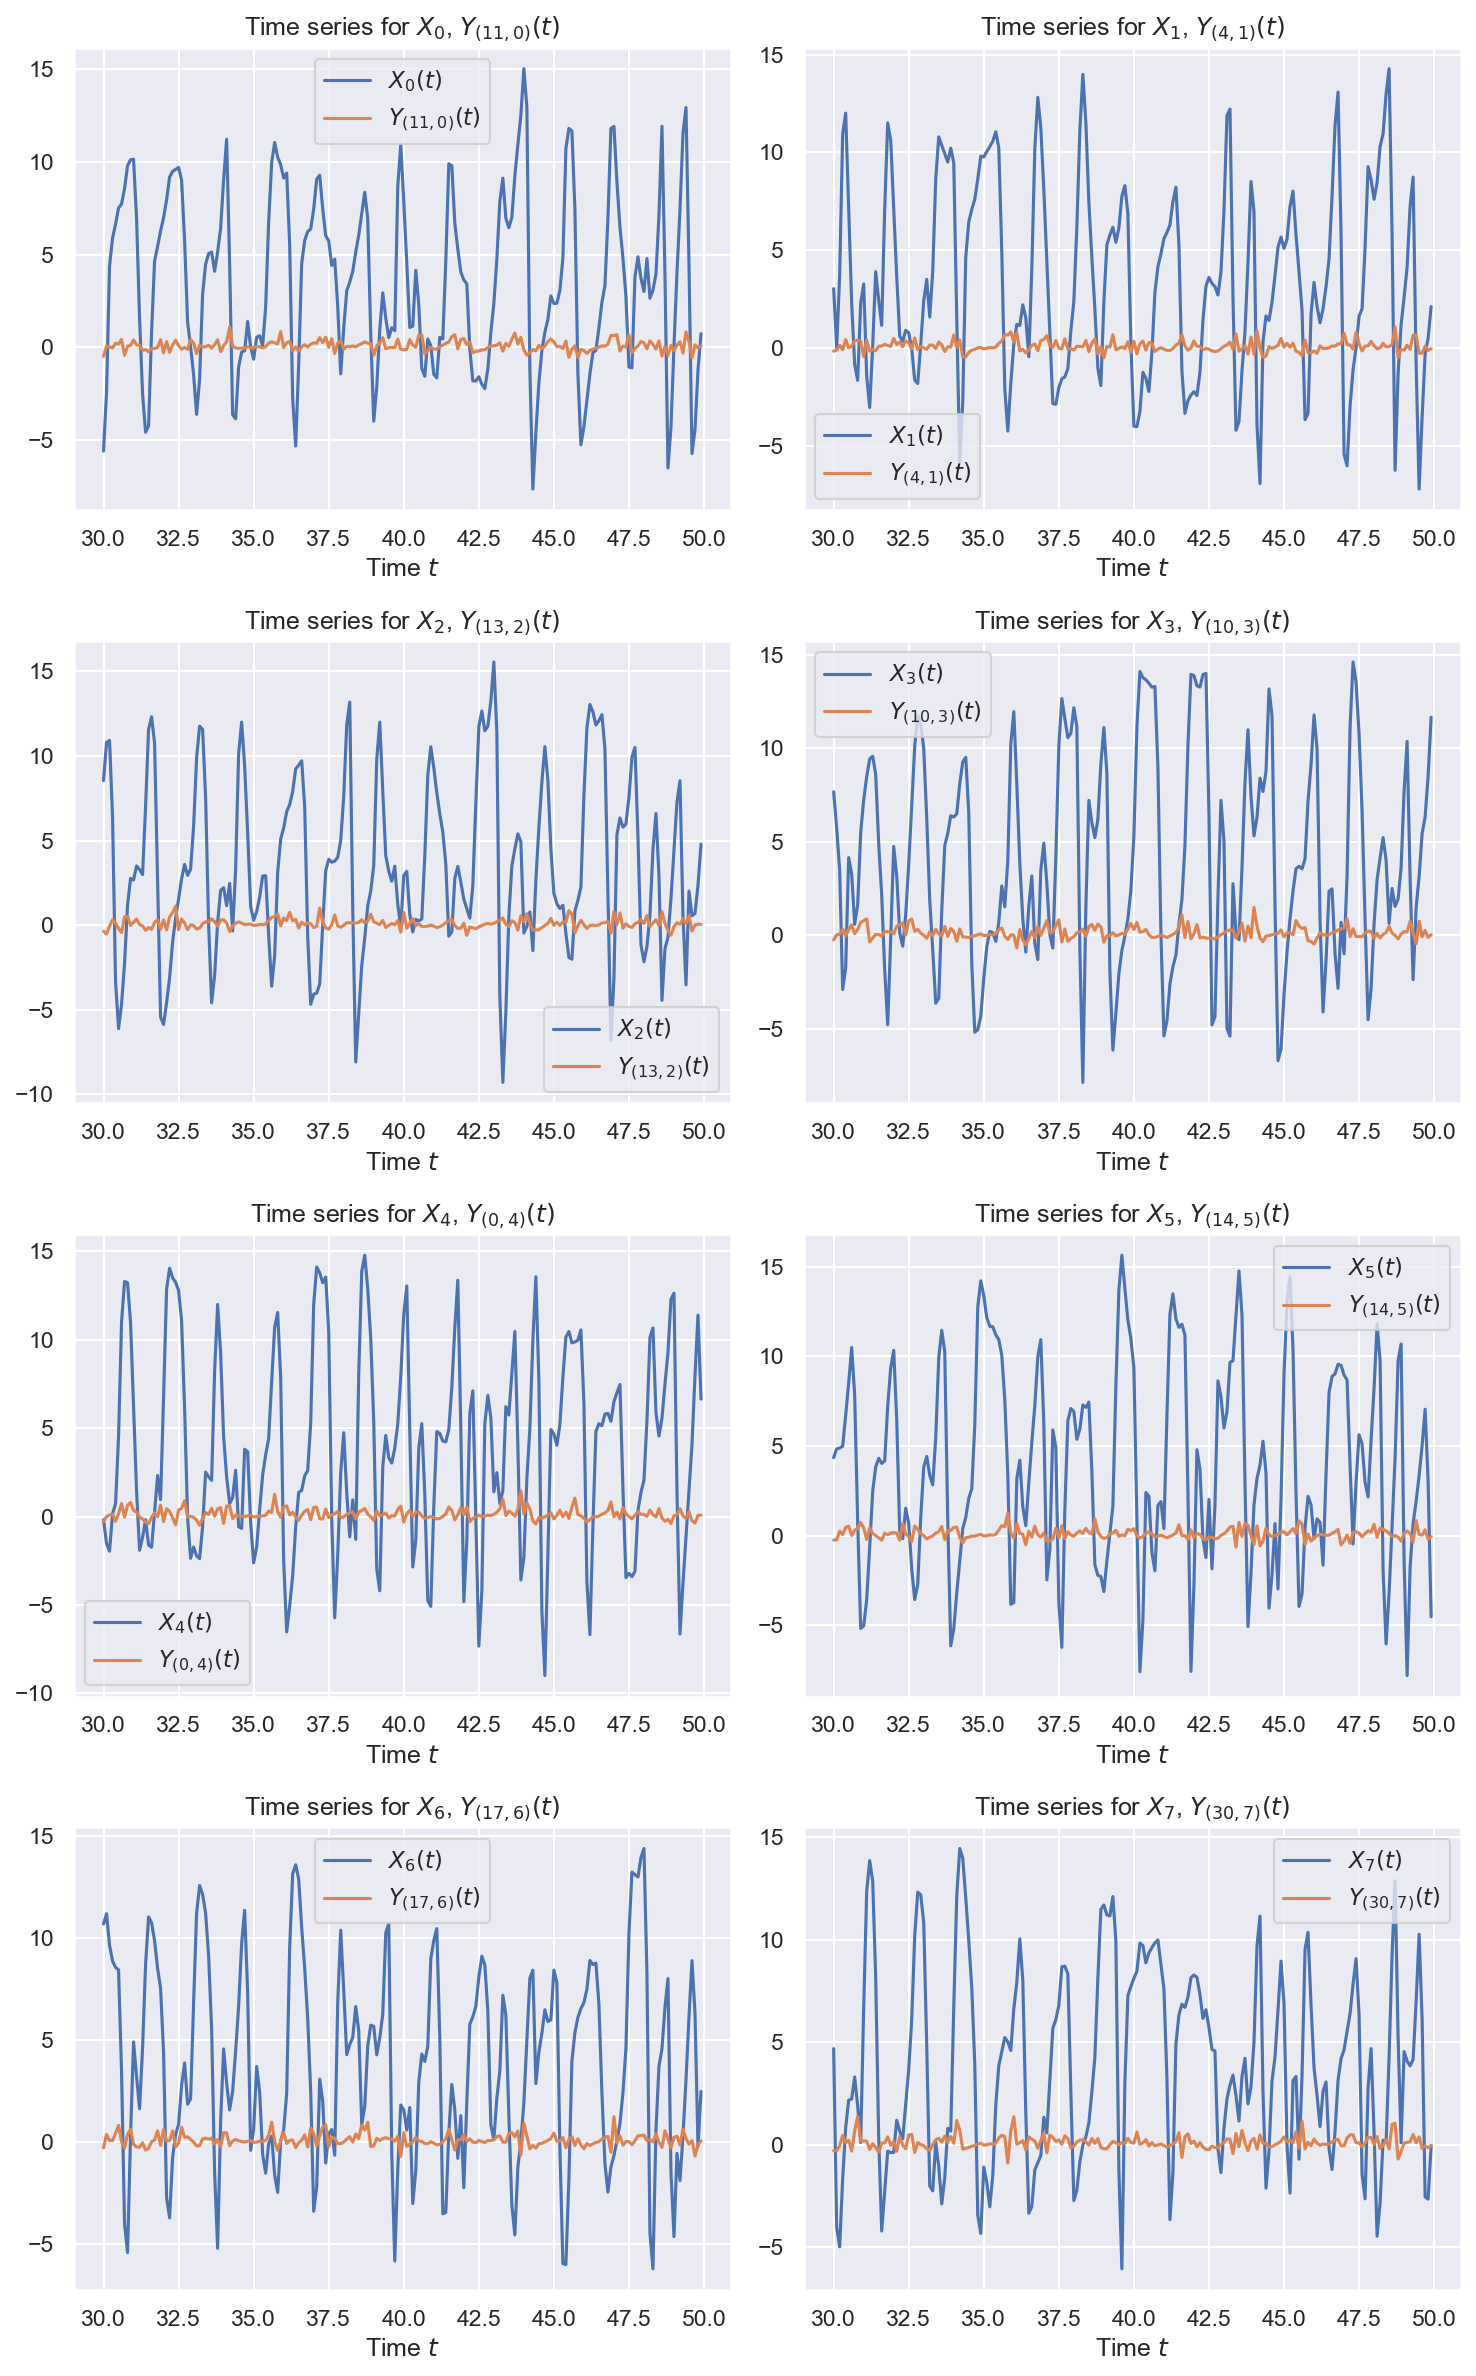

In [14]:
time_end = 200
fig = plot_l96_x_with_random_y(x_true, y_true, t, time_end, dpi=dpi, output_folder=save_folder, config=FLAGS)
plt.show()

### Select training data

In [15]:
train_index = int(FLAGS['train_perc'] * x_true.shape[0])

x_train, y_train, t_train, u_train = x_true[:train_index], y_true[:train_index], t[:train_index], u[:train_index]
x_train.shape

(300, 8)

## Deterministic parameterization

$U_p$ = Polynomial of order 3 (analogue to Arnold et al. 2013)

In [16]:
p3_coefs = poly.polyfit(x_train.flatten(), u_train.flatten(), 3)
p3_coefs

array([-6.82476588e-01, -1.11747949e+00, -1.04829537e-03,  3.00220514e-03])

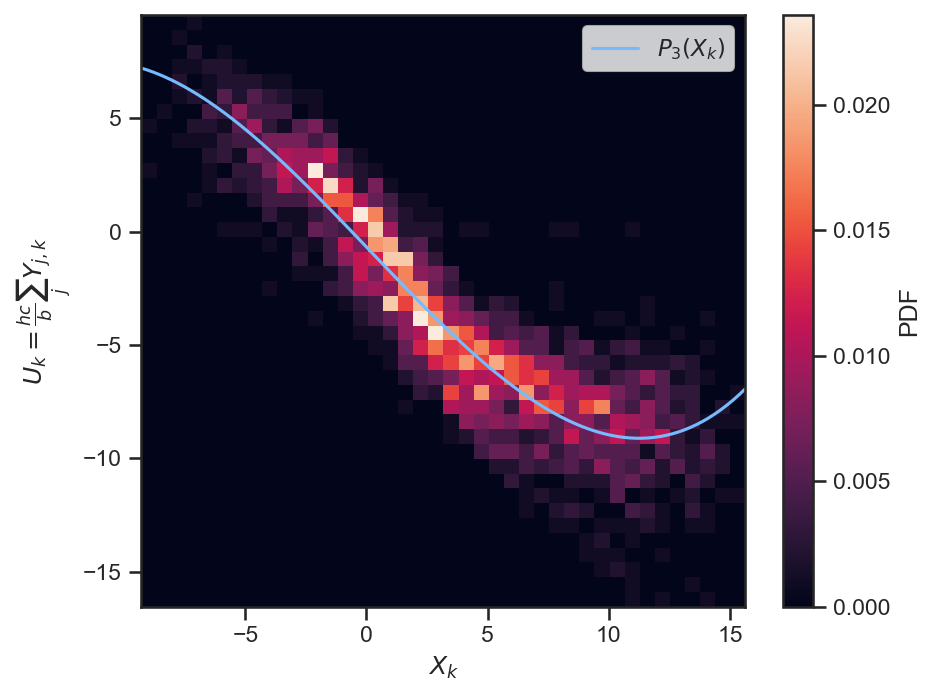

In [17]:
fig = plot_x_u_distribution_with_polynomial_fit(x_train, u_train, p3_coefs, 
                                                dpi=dpi,
                                                poly_label="$P_3(X_k)$",
                                                output_folder=save_folder, config=FLAGS)
plt.show()

## Stochastic parameterization

Analogue to Arnold et al. 2013:

$U_p = U_{det} + e(t)$

Model $e(t)$ as a first-order autoregressive (AR(1)) process: 

$e(t) = \phi e(t-\Delta t) + \sigma_e (1 - \phi^2)^{1/2} z(t)$

### Residuals

In [18]:
residuals = u_train - poly.polyval(x_train, p3_coefs) # y_data
residuals.shape

(300, 8)

In [19]:
time_idx = np.arange(0, residuals.shape[0], dtype=int) 
time_idx.shape

(300,)

### Fit with scipy.curve_fit

In [20]:
from parameterization.ar1_process import fit_ar1_noise_parameters, compute_ar1_noise

In [21]:
phi, sigma_e, phi_cov, sigma_e_cov = fit_ar1_noise_parameters(residuals, seed=FLAGS['seed'])
phi.shape

(8,)

In [22]:
ar1_noise = compute_ar1_noise(phi, sigma_e, residuals.shape[0], seed=FLAGS['seed'])

### Plots

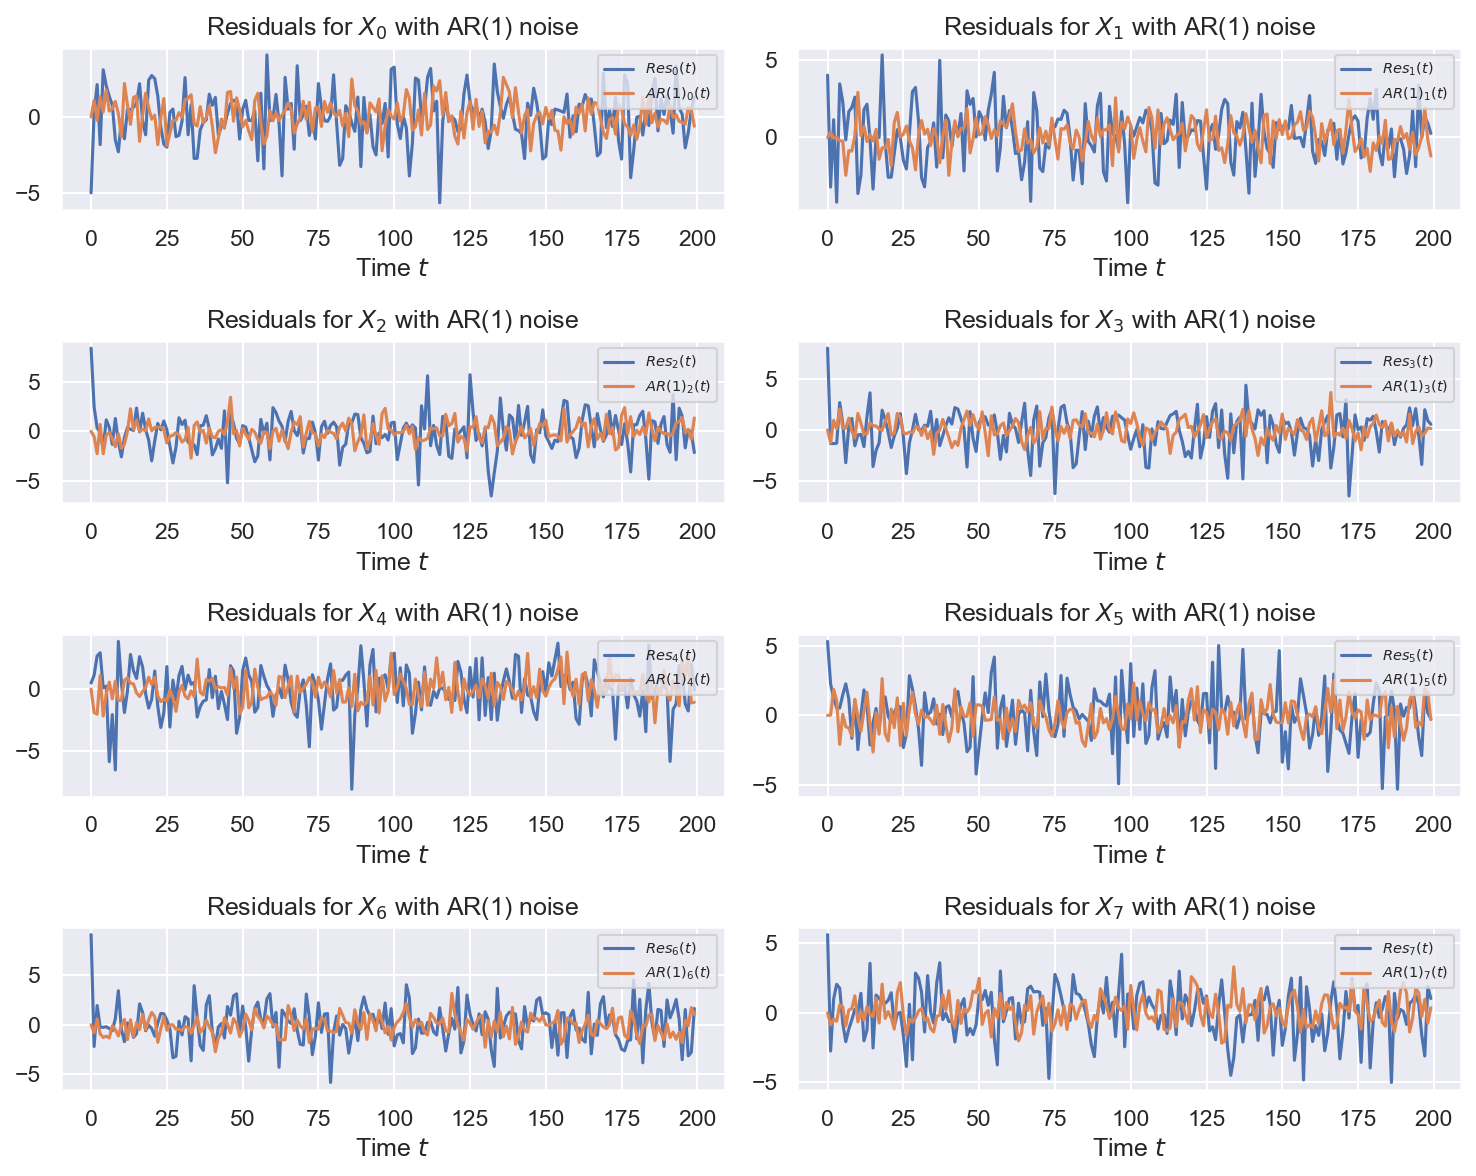

In [23]:
time_end = 200
plot_residuals_with_noise(residuals, ar1_noise, time_idx, time_end, dpi=dpi,
                          output_folder=save_folder, config=FLAGS)
plt.show()

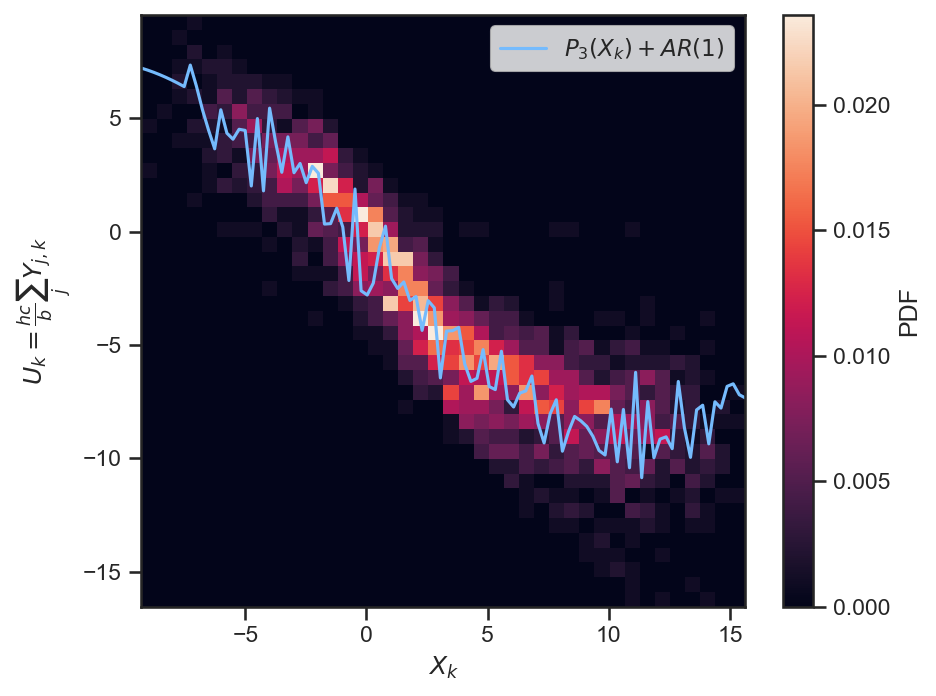

In [24]:
fig = plot_x_u_distribution_with_stochastic_polynomial_fit(x_train, u_train, 
                                                           p3_coefs, phi, sigma_e,
                                                           dpi=dpi, poly_label="$P_3(X_k) + AR(1)$",
                                                           output_folder=save_folder, config=FLAGS)

plt.show()

## GCM run with parameterization

In [25]:
from models.gcm import GCM, GCMManual
from parameterization.polynomial_ar1_param import PolynomialAR1Parameterization

In [26]:
if FLAGS['solver'] == 'manual': 
    GCM_model = GCMManual
else: 
    GCM_model = GCM

In [27]:
def run_gcm(gcm):
    if FLAGS['solver'] == 'manual': 
        print("Running manual GCM...")
        return gcm(init_conditions, dt=FLAGS['dt'], si=FLAGS['si'], t_total=FLAGS['t_total']) 
    else: 
        print("Running solver GCM...")
        return gcm(init_conditions, si=FLAGS['si'], t_total=FLAGS['t_total'], solver=FLAGS['solver'], solver_method=FLAGS['solver_method'])

In [28]:
FLAGS['dt'] = 1e-4
FLAGS['t_total'] = t_total_ens 

### Without parameterization

In [29]:
gcm_no_param = GCM_model(FLAGS['F'])
%time x_no_param, t_no_param = run_gcm(gcm_no_param)

Running manual GCM...
CPU times: user 1.9 s, sys: 9.71 ms, total: 1.91 s
Wall time: 1.97 s


In [30]:
save_output_gcm(output_folder, FLAGS, 'no_param', x_no_param, t_no_param, extra_ident=extra_ident)

### Deterministic parameterization 

In [31]:
det_param = lambda x:  poly.polyval(x, p3_coefs)

In [32]:
gcm_det_param = GCM_model(FLAGS['F'], det_param)
%time x_det_param, t_det_param = run_gcm(gcm_det_param)

Running manual GCM...
CPU times: user 5.62 s, sys: 18.3 ms, total: 5.64 s
Wall time: 5.7 s


In [33]:
save_output_gcm(output_folder, FLAGS, 'det_param',  x_det_param, t_det_param, extra_ident=extra_ident)


### Stochastic parameterization

In [34]:
stochastic_param = PolynomialAR1Parameterization(p3_coefs, phi, sigma_e, seed=FLAGS['seed'])

In [35]:
gcm_stoch_param = GCM_model(FLAGS['F'], stochastic_param)

%time x_stoch_param, t_stoch_param = run_gcm(gcm_stoch_param)

Running manual GCM...
CPU times: user 7.84 s, sys: 46.5 ms, total: 7.89 s
Wall time: 7.95 s


In [36]:
save_output_gcm(output_folder, FLAGS, 'stoch_param', x_stoch_param, t_stoch_param, extra_ident=extra_ident)

### Plots

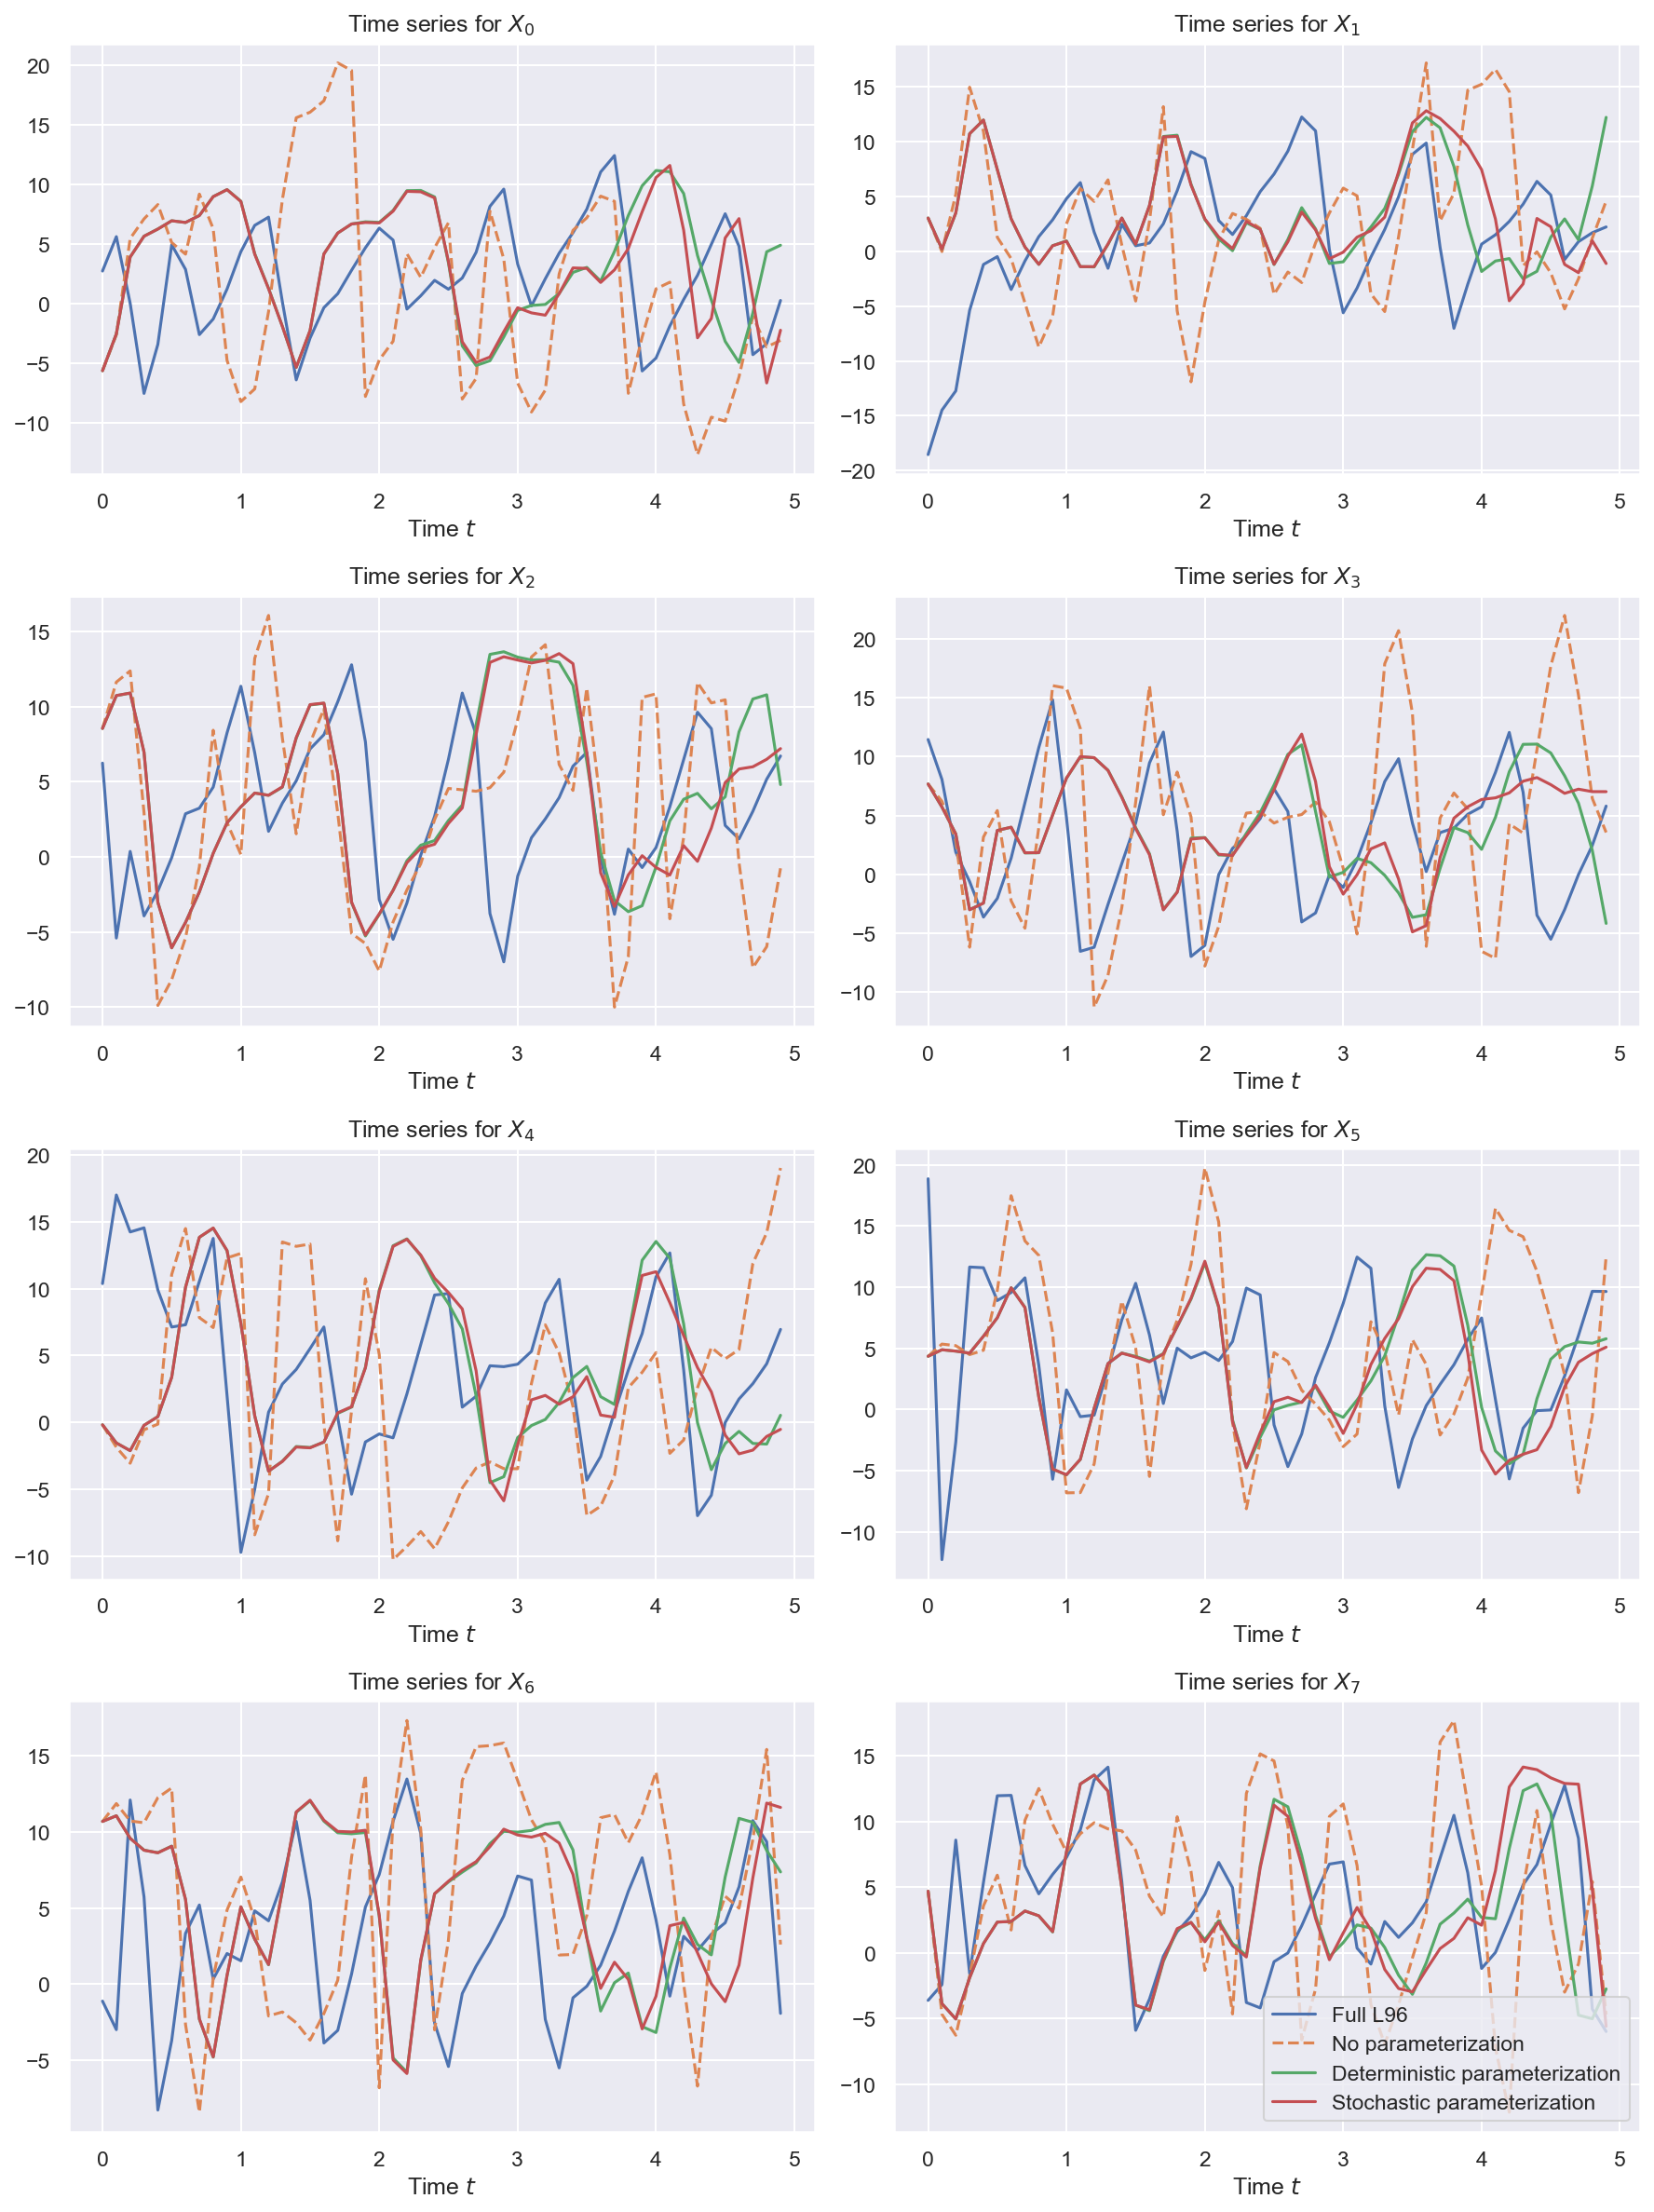

In [37]:
time_end = 50
fig = plot_gcm_time_series_comparison(t_no_param, x, x_no_param,
                                      x_det_param, x_stoch_param, time_end, time_start=0, dpi=dpi, output_folder=save_folder, config=FLAGS)
plt.show()

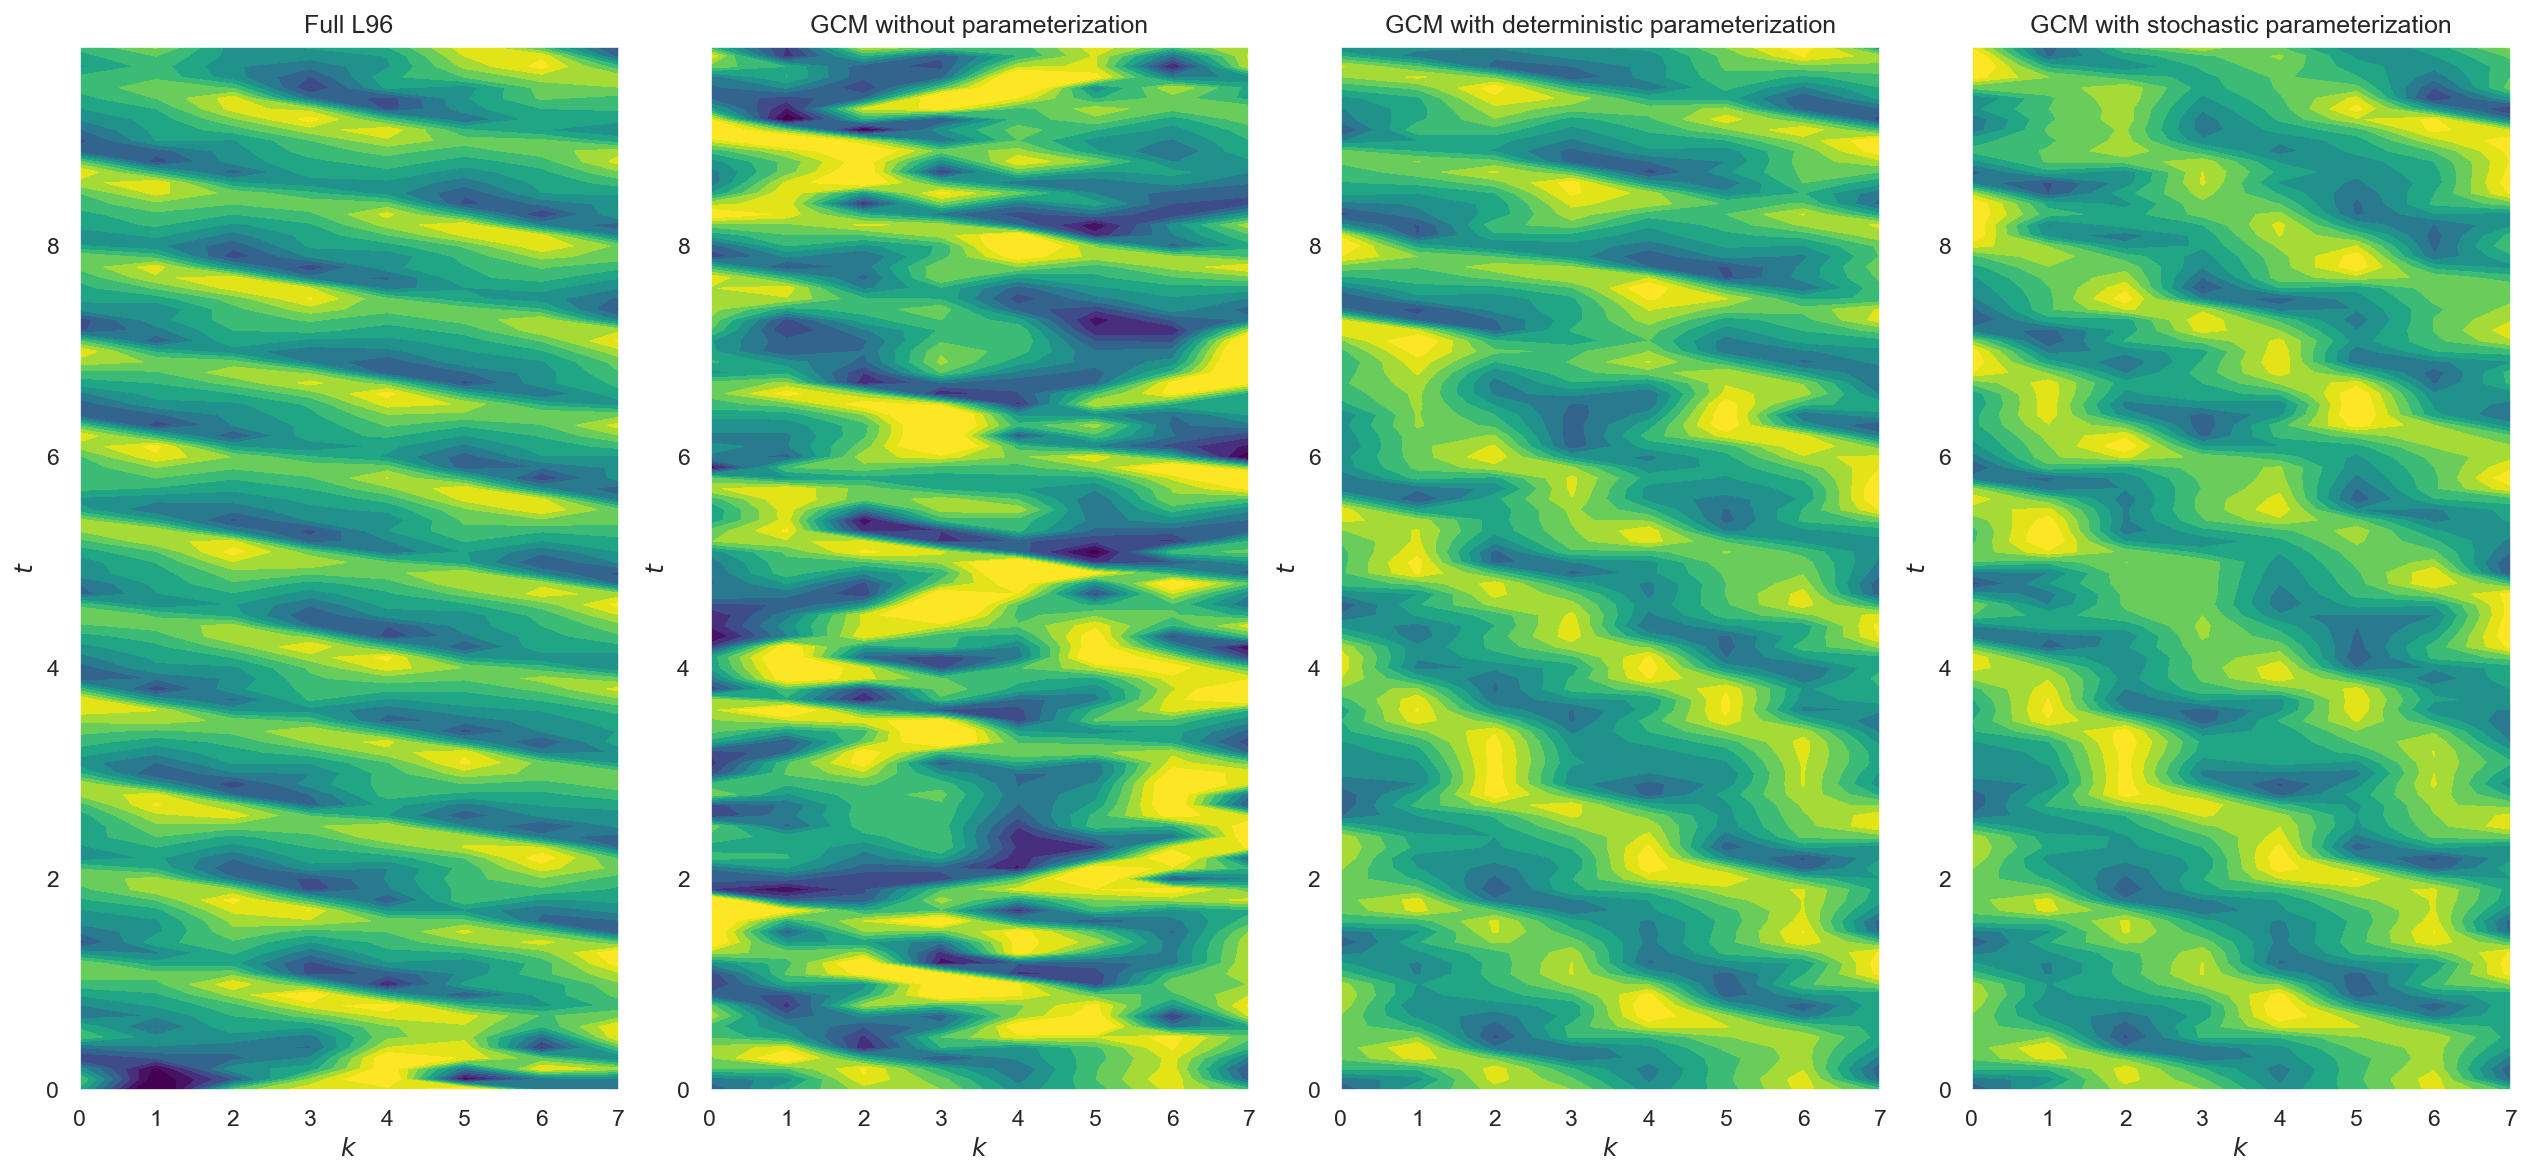

In [38]:
time_end = 100
fig = plot_gcm_contour_comparison(t_no_param, x, x_no_param, 
                                  x_det_param, x_stoch_param, time_end,
                                  time_start=0, dpi=dpi,
                                  output_folder=save_folder, config=FLAGS)
plt.show()


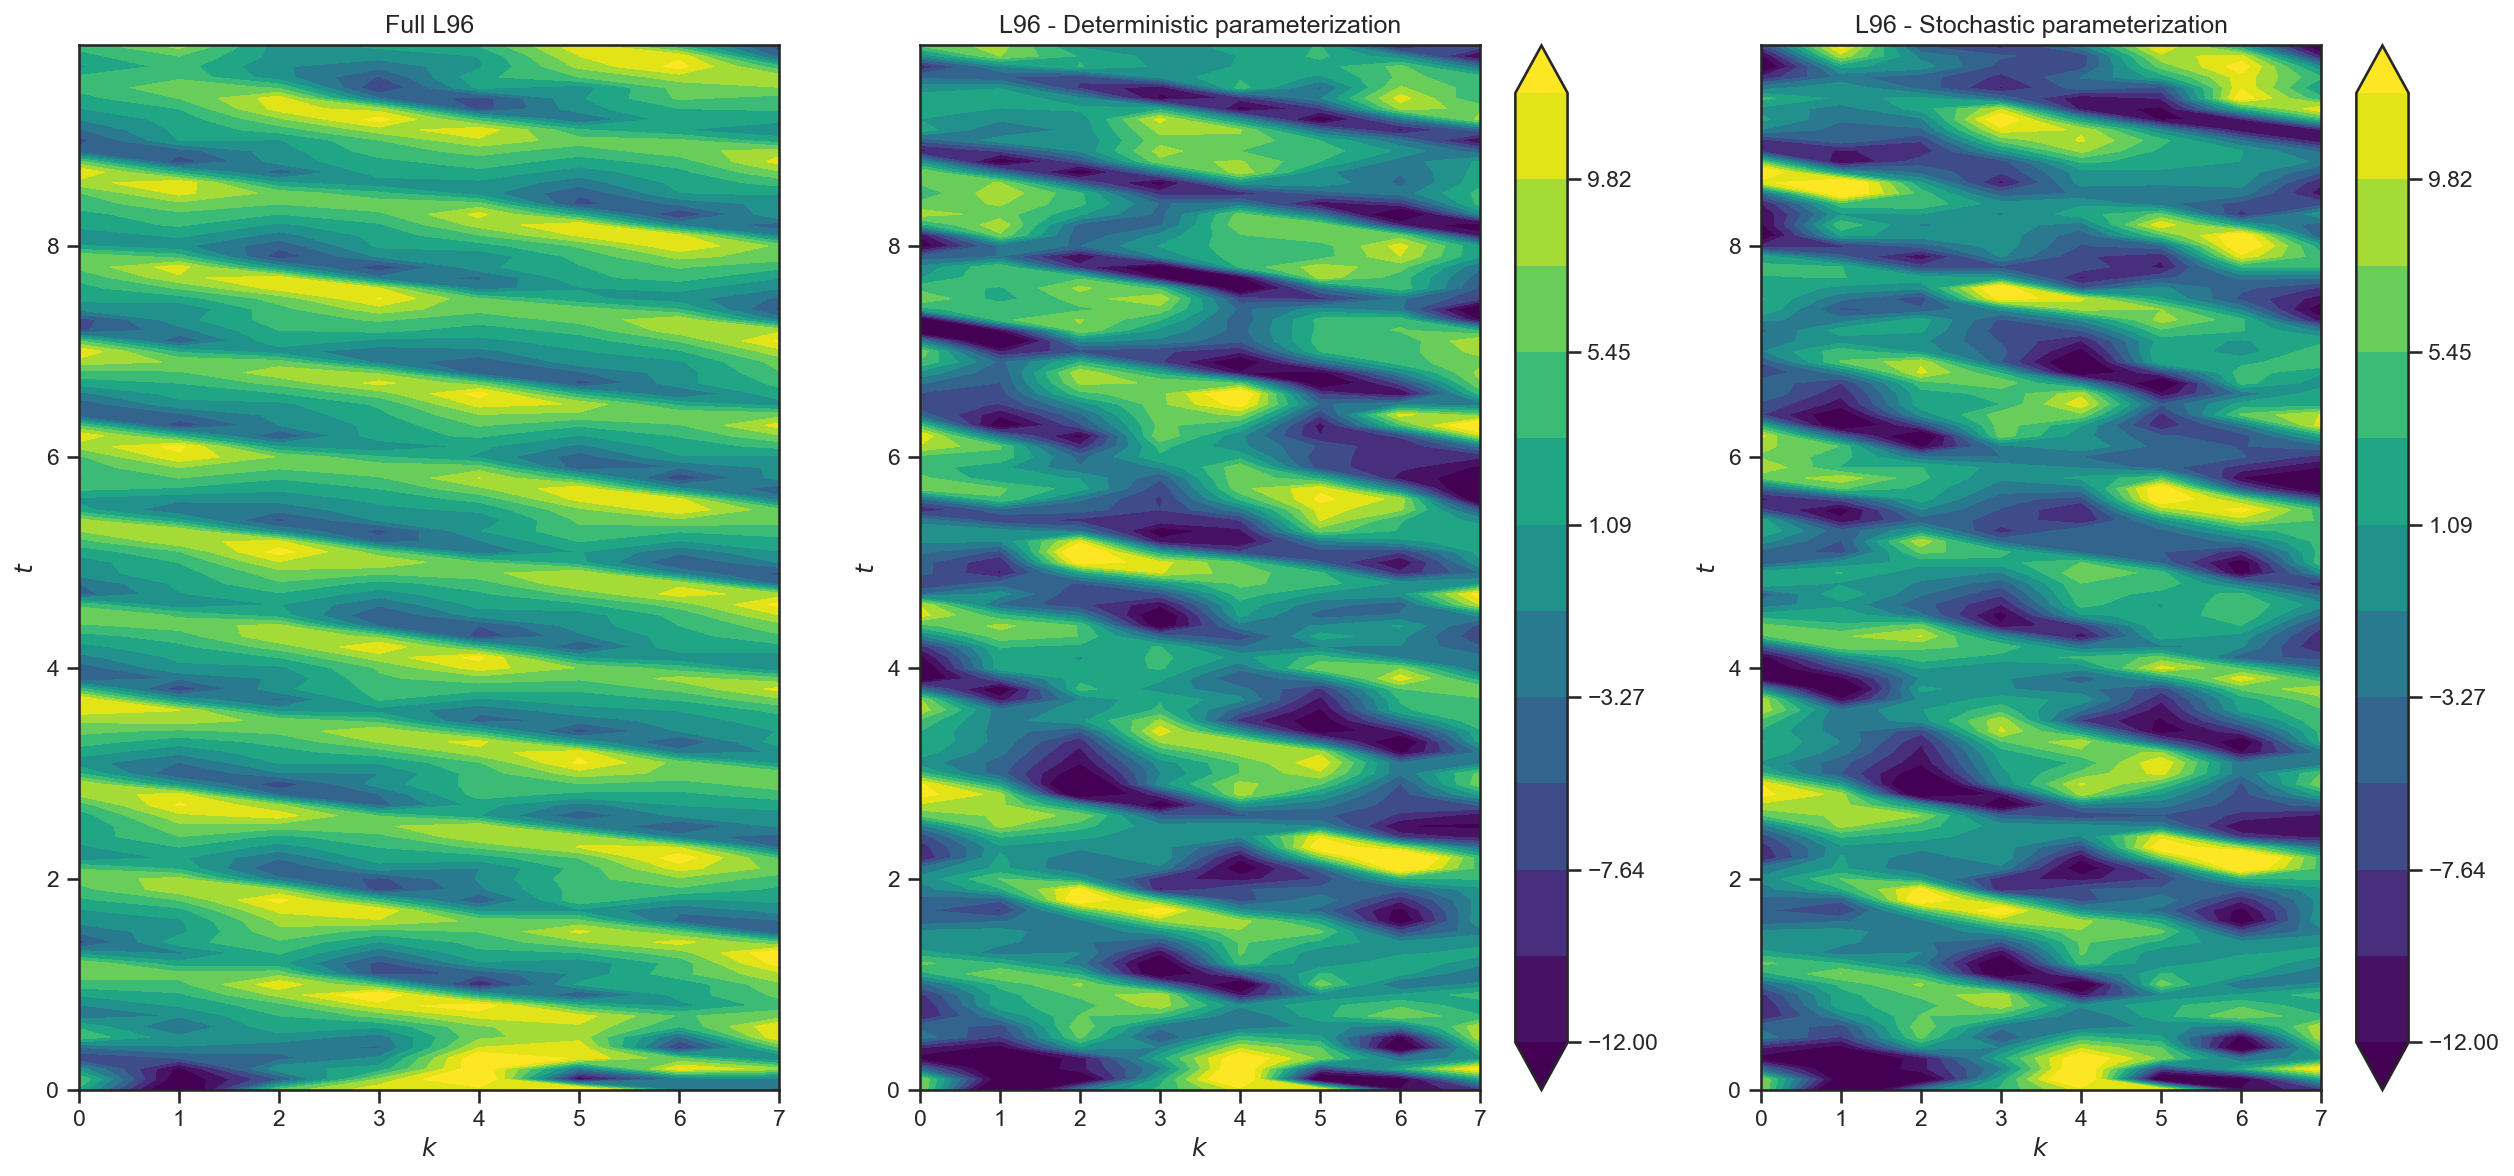

In [39]:
time_end = 100
fig = plot_gcm_contour_difference(t_no_param, x, 
                                  x_det_param, x_stoch_param, time_end,
                                  time_start=0, dpi=dpi,
                                  output_folder=save_folder, config=FLAGS)
plt.show()


## Ensemble run

In [40]:
from ensemble.gcm_polynomial_ar1 import run_stochastic_ensemble_parallel_multiprocessing, \
    run_stochastic_member_solver, run_stochastic_member_manual

### Generate initial states

In [41]:
FLAGS['dt'] = 1e-4
num_init_states = 3
num_ensemble_members = 3
t_total = t_total_ens

In [42]:
init_seeds = np.arange(0, num_init_states, dtype=int)      
spin_up = 30                   

In [43]:
init_states_x = np.zeros((num_init_states, FLAGS['K']))
init_states_y = np.zeros((num_init_states, FLAGS['K']*FLAGS['J']))
init_states_t = np.zeros((num_init_states,))

for i in range(num_init_states):
    l = L96(FLAGS['K'], FLAGS['J'], FLAGS['F'], FLAGS['h'],
            FLAGS['b'], FLAGS['c'], seed=init_seeds[i])
    x, y, t = l.run(si=FLAGS['si'], t_total=spin_up, store=True,
                    solver=FLAGS['solver'], solver_method=FLAGS['solver_method'])
    init_states_x[i] = l.x
    init_states_y[i] = l.y
    init_states_t[i] = l.t

### Perturb??

In [44]:
# perturb initial states
perturb = False

### Call wrapper

In [45]:
def run_ensemble(seeds):
    if FLAGS['solver'] == 'manual':
        return run_stochastic_ensemble_parallel_multiprocessing(init_states_x, FLAGS,
                                                                run_stochastic_member_manual,
                                                                p3_coefs, phi, sigma_e, seeds,
                                                                perturb, FLAGS['dt'])
    else:
        return run_stochastic_ensemble_parallel_multiprocessing(init_states_x, FLAGS,
                                                                run_stochastic_member_solver,
                                                                p3_coefs, phi, sigma_e, seeds, perturb,
                                                                FLAGS['solver'], FLAGS['solver_method'])

### Multiple initial states, single stochastic model run per state

In [47]:
FLAGS['t_total'] = t_total 
# Number of initial states
FLAGS['n_init_states'] = num_init_states
# Number of ensemble members
FLAGS['n_ens'] = 1

# We use different seeds than when creating the initial states
# We want a distinct seed for each ensemble member (i.e. each initial state)
# +1 seed is used for perturbation of initial conditions (if specified) 
seeds = np.arange(len(init_seeds), 
                  len(init_seeds) + FLAGS['n_init_states']  + 1, 
                  dtype=int)                         

%time x_stoch_ens, t_stoch_ens = run_ensemble(seeds)

CPU times: user 19.1 ms, sys: 59.1 ms, total: 78.2 ms
Wall time: 9.3 s


In [48]:
save_output_ensemble(output_folder, FLAGS, 'stoch_param', x_stoch_ens, 
                     t_stoch_ens, seeds, extra_ident=extra_ident)

### Single initial state, multiple stochastic runs

In [49]:
FLAGS['t_total'] = t_total 
# Number of initial states
FLAGS['n_init_states'] = 1
# Number of ensemble members
FLAGS['n_ens'] = num_ensemble_members


seeds = np.arange(len(init_seeds), 
                  len(init_seeds) + FLAGS['n_ens'] + 1, 
                  dtype=int)                         


%time x_stoch_ens, t_stoch_ens = run_ensemble(seeds)

CPU times: user 9.1 ms, sys: 45.8 ms, total: 54.9 ms
Wall time: 9.14 s


In [50]:
save_output_ensemble(output_folder, FLAGS, 'stoch_param', x_stoch_ens, 
                     t_stoch_ens, seeds, extra_ident=extra_ident)

## L96 ensemble

In [51]:
from ensemble.l96_parallel import run_l96_parallel

### Multiple initial states

In [52]:
FLAGS['t_total'] = t_total
# Number of initial states
FLAGS['n_init_states'] = num_init_states
# Number of ensemble members
FLAGS['n_ens'] = 1

seed = len(init_seeds) + FLAGS['n_init_states'] + 1

%time x_per_state, y_per_state, t_per_state, u_per_state = run_l96_parallel(\
    init_states_x, init_states_y, init_states_t, FLAGS, \
        perturb=perturb, seed=seed)

CPU times: user 9.75 ms, sys: 47.2 ms, total: 56.9 ms
Wall time: 20.9 s


In [53]:
save_output_l96_ensemble_simulation(output_folder, FLAGS, x_per_state,
                                    y_per_state, t_per_state, u_per_state,
                                    seeds=seeds)